In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string

# For text processing and modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# For splitting data and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# For plotting
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [2]:
# Load the dataset
# Make sure 'reviews.csv' is uploaded to your Colab session
try:
    df = pd.read_csv('reviews.csv')
    print("Dataset loaded successfully.")
    print(df.head())
except FileNotFoundError:
    print("Error: 'reviews.csv' not found.")
    print("Please upload the file to your Colab environment.")

Dataset loaded successfully.
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
def clean_text(text):
    """
    Cleans text data by removing HTML tags, converting to lowercase,
    and removing punctuation.
    """
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function
if 'df' in locals():
    df['cleaned_review'] = df['review'].apply(clean_text)

    # Map sentiment to binary values
    df['sentiment_label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

    print("Data after cleaning and mapping:")
    print(df[['cleaned_review', 'sentiment_label']].head())

Data after cleaning and mapping:
                                      cleaned_review  sentiment_label
0  one of the other reviewers has mentioned that ...                1
1  a wonderful little production the filming tech...                1
2  i thought this was a wonderful way to spend ti...                1
3  basically theres a family where a little boy j...                0
4  petter matteis love in the time of money is a ...                1


In [4]:
# Define Tokenizer parameters
VOCAB_SIZE = 10000  # You can adjust this
OOV_TOKEN = "<OOV>" # Out-of-vocabulary token

# Initialize and fit the Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

if 'df' in locals():
    tokenizer.fit_on_texts(df['cleaned_review'])

    # The word_index contains the mapping
    word_index = tokenizer.word_index
    print(f"Vocabulary size: {len(word_index)}")
    print("First 10 words in vocabulary:", dict(list(word_index.items())[0:10]))

Vocabulary size: 115433
First 10 words in vocabulary: {'<OOV>': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'to': 6, 'is': 7, 'in': 8, 'it': 9, 'this': 10}


In [5]:
# Define padding parameters
MAX_LENGTH = 200     # Maximum length of a review (in words)
PADDING_TYPE = 'post'  # Pad at the end of the sequence
TRUNC_TYPE = 'post'   # Truncate at the end of the sequence

if 'df' in locals():
    # Convert texts to sequences of integers
    sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

    # Pad/truncate the sequences
    padded_sequences = pad_sequences(sequences,
                                     maxlen=MAX_LENGTH,
                                     padding=PADDING_TYPE,
                                     truncating=TRUNC_TYPE)

    print("Shape of padded sequences tensor:", padded_sequences.shape)
    print("Example padded sequence:", padded_sequences[0])

Shape of padded sequences tensor: (17464, 200)
Example padded sequence: [  28    5    2   78 1927   44 1027   12  102  145   39  485 3288  360
  470   26 2932   34   24  215   14   10    7  625   47  601   15 7749
   84  146   12 3224   69   42 3288   13   29 5251    4    1  132    5
  585   60  274    8  215   35    2  609  137 1808   69   10    7   22
    3  117   16    2 7243 6668   40    1   10  117 2647   53 7244   15
 5992    6 1473  386   40  585   29    7 3430    8    2  346  342    5
    2    1    7  457 3288   14   12    7    2    1  343    6    2    1
 6669 2512 1064    1    9 2689 1282   20    1  533   33 4639 2690    5
    2 1225  111   31    2 6943   25 3368    1    4  403    1   38    1
    7   22  316   20    2 5416 3929  533    7  336    6    1 8361    1
    1 6670 7921 2727    4    1    1  332 7750 7396    1    4 9688    1
   24  108  221    1   57  125    2  264 1328    5    2  117    7  650
    6    2  187   12    9  260  111   78  249  534 2795  811  175 1241
 3930

In [6]:
if 'df' in locals():
    # Get labels
    labels = df['sentiment_label'].values

    # First split: 80% train+val, 20% test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        padded_sequences, labels, test_size=0.20, random_state=42
    )

    # Second split: 80% train, 20% val (from the 80% train+val set)
    # This results in 64% train, 16% val, 20% test overall
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.20, random_state=42
    )

    print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
    print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
    print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training data shape: (11176, 200), Labels shape: (11176,)
Validation data shape: (2795, 200), Labels shape: (2795,)
Test data shape: (3493, 200), Labels shape: (3493,)


In [7]:
# Model Hyperparameters
EMBEDDING_DIM = 100
# VOCAB_SIZE was defined during tokenization (e.g., 10000)
# MAX_LENGTH was defined during padding (e.g., 200)
RNN_UNITS = 64
LSTM_UNITS = 64
B_LSTM_UNITS = 64
DENSE_UNITS = 64
NUM_EPOCHS = 10
BATCH_SIZE = 64

# Use VOCAB_SIZE + 1 because tokenizer is 1-based and 0 is for padding
EFFECTIVE_VOCAB_SIZE = VOCAB_SIZE + 1

In [28]:
# Build Model 1: Simple RNN
model_rnn = Sequential([
    # Input_dim is VOCAB_SIZE + 1 (for the 0 padding token)
    Embedding(EFFECTIVE_VOCAB_SIZE, EMBEDDING_DIM), # Removed input_length
    SimpleRNN(RNN_UNITS),
    Dense(DENSE_UNITS, activation='relu'),
    Dropout(0.5), # Added dropout for regularization
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

# Compile the model
model_rnn.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model_rnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
print("Training RNN model...")

# Add EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

if 'X_train' in locals():
    history_rnn = model_rnn.fit(
        X_train, y_train,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    print("RNN Training complete.")
else:
    print("Training data not found. Please run previous cells.")

Training RNN model...
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.5092 - loss: 0.7066 - val_accuracy: 0.4848 - val_loss: 0.6969
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.4925 - loss: 0.6989 - val_accuracy: 0.5038 - val_loss: 0.6944
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.5134 - loss: 0.6931 - val_accuracy: 0.5091 - val_loss: 0.6935
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.5293 - loss: 0.6887 - val_accuracy: 0.5020 - val_loss: 0.6951
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.5511 - loss: 0.6796 - val_accuracy: 0.5084 - val_loss: 0.6985
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.6344 - loss: 0.5949 - val_accuracy: 0.5245 - val_loss: 0.7533
RNN Training complete.


In [10]:
def evaluate_model(model, model_name, X_test, y_test):
    """
    Evaluates a trained model on the test set and returns a dictionary of metrics.
    """
    # Get probability predictions
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to binary classes (0 or 1)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"--- Evaluation Metrics for {model_name} ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("------------------------------------------")

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }, y_pred_probs # Return probs for ensemble

In [11]:
def plot_loss_curves(history, model_name):
    """
    Plots the training and validation loss curves from a Keras history object.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
--- Evaluation Metrics for Simple RNN ---
Accuracy:  0.5156
Precision: 0.5113
Recall:    0.7486
F1-Score:  0.6076
------------------------------------------


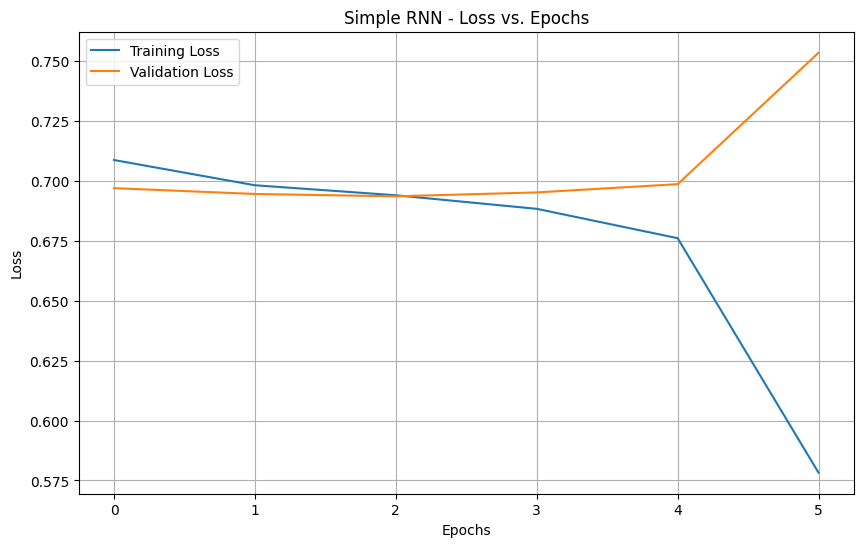

In [12]:
# Evaluate the RNN model
if 'model_rnn' in locals():
    rnn_metrics, rnn_probs = evaluate_model(model_rnn, "Simple RNN", X_test, y_test)

    # Plot the loss curves
    plot_loss_curves(history_rnn, "Simple RNN")
else:
    print("RNN model not trained. Please run cell 9.")

In [13]:
# Build Model 2: LSTM
model_lstm = Sequential([
    Embedding(EFFECTIVE_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    # Use LSTM layer instead of SimpleRNN
    LSTM(LSTM_UNITS),
    Dense(DENSE_UNITS, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
print("Training LSTM model...")

if 'X_train' in locals():
    history_lstm = model_lstm.fit(
        X_train, y_train,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping], # Use the same early stopping
        verbose=1
    )
    print("LSTM Training complete.")
else:
    print("Training data not found. Please run previous cells.")

Training LSTM model...
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - accuracy: 0.5019 - loss: 0.6935 - val_accuracy: 0.5016 - val_loss: 0.6924
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 46s 264ms/step - accuracy: 0.5396 - loss: 0.6809 - val_accuracy: 0.5717 - val_loss: 0.6626
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 39s 225ms/step - accuracy: 0.6522 - loss: 0.5768 - val_accuracy: 0.6186 - val_loss: 0.6223
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.6816 - loss: 0.5348 - val_accuracy: 0.5288 - val_loss: 0.6922
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 40s 225ms/step - accuracy: 0.5361 - loss: 0.6754 - val_accuracy: 0.5893 - val_loss: 0.6858
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.7035 - loss: 0.4998 - val_accuracy: 0.7603 - val_loss: 0.5770
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.8862 - loss: 0.2968 - val_accuracy: 0.8204 - val_loss: 0.5009
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 40s 228ms/step - acc

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
--- Evaluation Metrics for LSTM ---
Accuracy:  0.8268
Precision: 0.8541
Recall:    0.7891
F1-Score:  0.8203
------------------------------------------


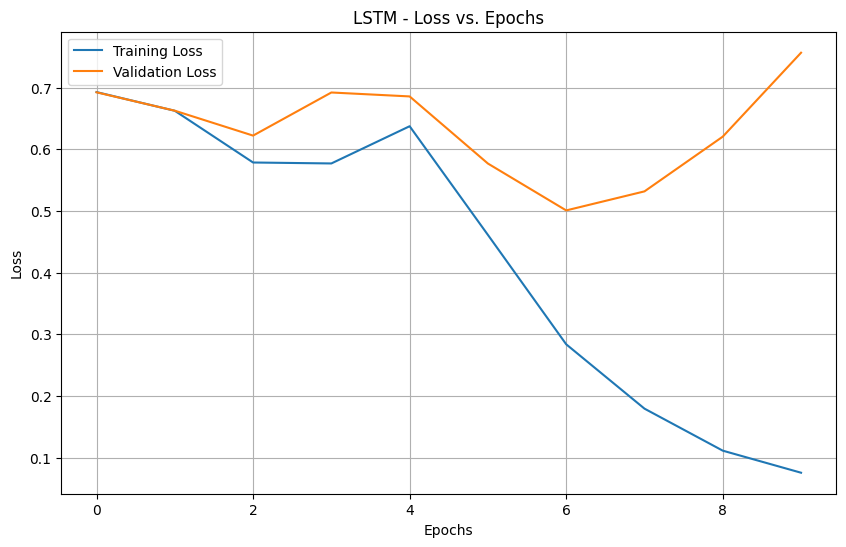

In [15]:
# Evaluate the LSTM model
if 'model_lstm' in locals():
    lstm_metrics, lstm_probs = evaluate_model(model_lstm, "LSTM", X_test, y_test)

    # Plot the loss curves
    plot_loss_curves(history_lstm, "LSTM")
else:
    print("LSTM model not trained. Please run cell 14.")

In [16]:
# Build Model 3: Bidirectional LSTM
model_bilstm = Sequential([
    Embedding(EFFECTIVE_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    # Use a Bidirectional wrapper on the LSTM layer
    Bidirectional(LSTM(B_LSTM_UNITS)),
    Dense(DENSE_UNITS, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_bilstm.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model_bilstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
print("Training Bidirectional LSTM model...")

if 'X_train' in locals():
    history_bilstm = model_bilstm.fit(
        X_train, y_train,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    print("BiLSTM Training complete.")
else:
    print("Training data not found. Please run previous cells.")

Training Bidirectional LSTM model...
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 79s 424ms/step - accuracy: 0.6006 - loss: 0.6309 - val_accuracy: 0.7614 - val_loss: 0.4890
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 74s 424ms/step - accuracy: 0.8515 - loss: 0.3714 - val_accuracy: 0.8290 - val_loss: 0.3968
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 423ms/step - accuracy: 0.9294 - loss: 0.2085 - val_accuracy: 0.8204 - val_loss: 0.4389
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 73s 415ms/step - accuracy: 0.9450 - loss: 0.1593 - val_accuracy: 0.8390 - val_loss: 0.5387
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 75s 427ms/step - accuracy: 0.9709 - loss: 0.0876 - val_accuracy: 0.8293 - val_loss: 0.6592
BiLSTM Training complete.


110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step
--- Evaluation Metrics for Bidirectional LSTM ---
Accuracy:  0.8382
Precision: 0.8611
Recall:    0.8074
F1-Score:  0.8334
------------------------------------------


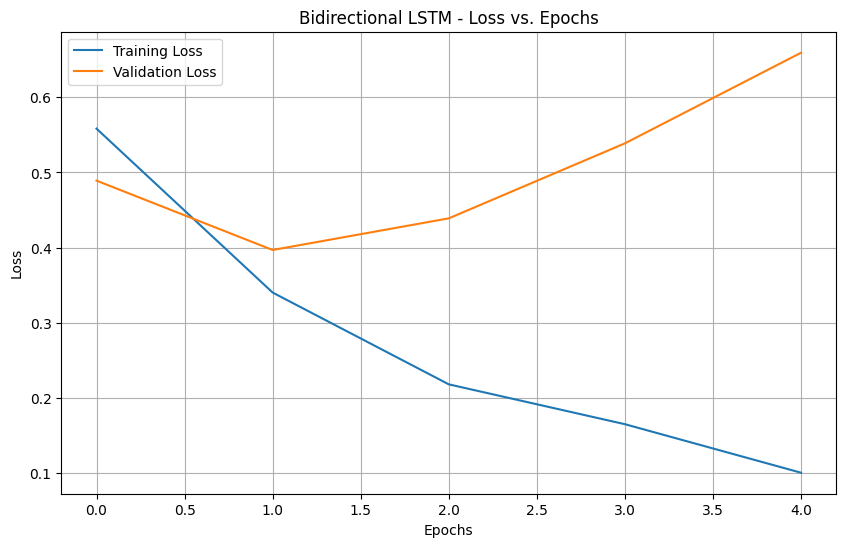

In [18]:
# Evaluate the BiLSTM model
if 'model_bilstm' in locals():
    bilstm_metrics, bilstm_probs = evaluate_model(model_bilstm, "Bidirectional LSTM", X_test, y_test)

    # Plot the loss curves
    plot_loss_curves(history_bilstm, "Bidirectional LSTM")
else:
    print("BiLSTM model not trained. Please run cell 17.")

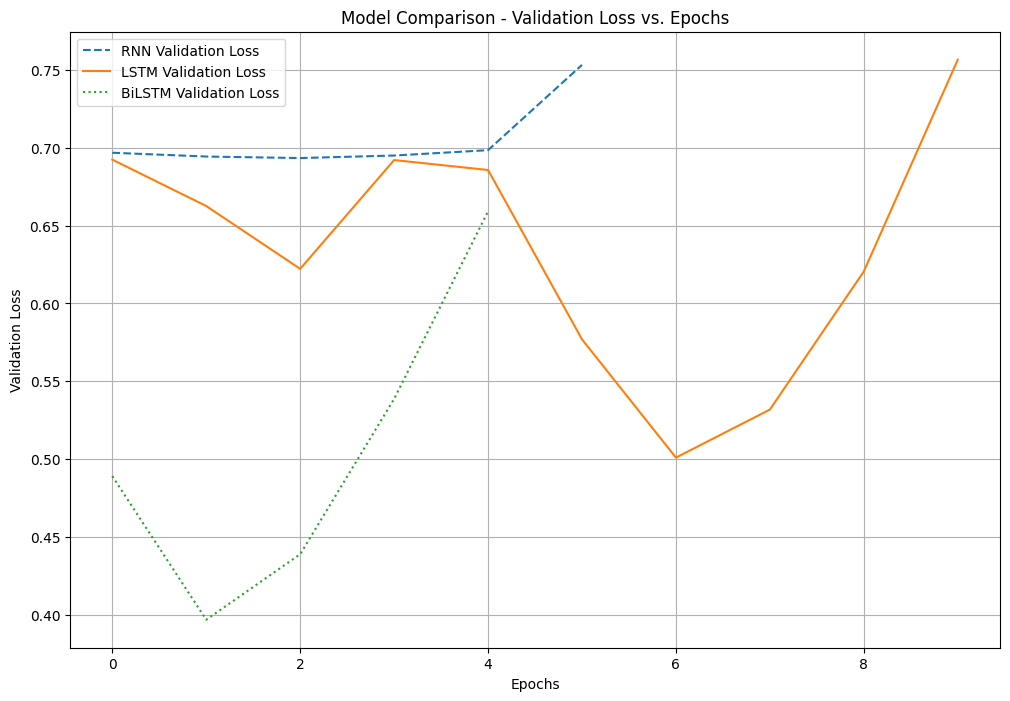

In [19]:
if 'history_rnn' in locals() and 'history_lstm' in locals() and 'history_bilstm' in locals():
    plt.figure(figsize=(12, 8))

    plt.plot(history_rnn.history['val_loss'], label='RNN Validation Loss', linestyle='--')
    plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss', linestyle='-')
    plt.plot(history_bilstm.history['val_loss'], label='BiLSTM Validation Loss', linestyle=':')

    plt.title('Model Comparison - Validation Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("One or more models have not been trained. Please run all training cells.")

In [20]:
# Create a comparison table
if 'rnn_metrics' in locals() and 'lstm_metrics' in locals() and 'bilstm_metrics' in locals():
    metrics_list = [rnn_metrics, lstm_metrics, bilstm_metrics]
    comparison_df = pd.DataFrame(metrics_list)
    comparison_df = comparison_df.set_index("Model")

    print("--- Performance Comparison Table ---")
    print(comparison_df.to_markdown(floatfmt=".4f"))
else:
    print("One or more models have not been evaluated. Please run all evaluation cells.")

--- Performance Comparison Table ---
| Model              |   Accuracy |   Precision |   Recall |   F1-Score |
|:-------------------|-----------:|------------:|---------:|-----------:|
| Simple RNN         |     0.5156 |      0.5113 |   0.7486 |     0.6076 |
| LSTM               |     0.8268 |      0.8541 |   0.7891 |     0.8203 |
| Bidirectional LSTM |     0.8382 |      0.8611 |   0.8074 |     0.8334 |


In [26]:
if 'rnn_probs' in locals() and 'lstm_probs' in locals() and 'bilstm_probs' in locals():
    print("--- Evaluating Ensemble Models ---")

    # 1. Average Probabilities
    avg_probs = (rnn_probs + lstm_probs + bilstm_probs) / 3
    y_pred_avg = (avg_probs > 0.5).astype(int)

    print("\n--- Ensemble: Average Probabilities ---")
    avg_accuracy = accuracy_score(y_test, y_pred_avg)
    avg_precision = precision_score(y_test, y_pred_avg)
    avg_recall = recall_score(y_test, y_pred_avg)
    avg_f1 = f1_score(y_test, y_pred_avg)

    print(f"Accuracy:  {avg_accuracy:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall:    {avg_recall:.4f}")
    print(f"F1-Score:  {avg_f1:.4f}")

    # 2. Majority Voting
    pred_rnn = (rnn_probs > 0.5).astype(int).flatten() # Flatten the predictions
    pred_lstm = (lstm_probs > 0.5).astype(int).flatten() # Flatten the predictions
    pred_bilstm = (bilstm_probs > 0.5).astype(int).flatten() # Flatten the predictions

    # Sum the predictions (e.g., 1+1+0=2). If sum >= 2, final pred is 1.
    sum_preds = pred_rnn + pred_lstm + pred_bilstm
    y_pred_majority = (sum_preds >= 2).astype(int)

    print("\n--- Ensemble: Majority Voting ---")
    maj_accuracy = accuracy_score(y_test, y_pred_majority)
    maj_precision = precision_score(y_test, y_pred_majority)
    maj_recall = recall_score(y_test, y_pred_majority)
    maj_f1 = f1_score(y_test, y_pred_majority)

    print(f"Accuracy:  {maj_accuracy:.4f}")
    print(f"Precision: {maj_precision:.4f}")
    print(f"Recall:    {maj_recall:.4f}")
    print(f"F1-Score:  {maj_f1:.4f}")

    # Add to comparison DataFrame
    ensemble_avg_metrics = {"Model": "Ensemble (Avg)", "Accuracy": avg_accuracy, "Precision": avg_precision, "Recall": avg_recall, "F1-Score": avg_f1}
    ensemble_maj_metrics = {"Model": "Ensemble (Vote)", "Accuracy": maj_accuracy, "Precision": maj_precision, "Recall": maj_recall, "F1-Score": maj_f1}

    comparison_df = pd.concat([comparison_df, pd.DataFrame([ensemble_avg_metrics, ensemble_maj_metrics]).set_index("Model")])

    print("\n--- Final Comparison Table (with Ensembles) ---")
    print(comparison_df.to_markdown(floatfmt=".4f"))

else:
    print("Model probabilities not found. Please run all evaluation cells.")

--- Evaluating Ensemble Models ---

--- Ensemble: Average Probabilities ---
Accuracy:  0.8517
Precision: 0.8807
Recall:    0.8143
F1-Score:  0.8462

--- Ensemble: Majority Voting ---
Accuracy:  0.8394
Precision: 0.8380
Recall:    0.8423
F1-Score:  0.8401

--- Final Comparison Table (with Ensembles) ---
| Model              |   Accuracy |   Precision |   Recall |   F1-Score |
|:-------------------|-----------:|------------:|---------:|-----------:|
| Simple RNN         |     0.5156 |      0.5113 |   0.7486 |     0.6076 |
| LSTM               |     0.8268 |      0.8541 |   0.7891 |     0.8203 |
| Bidirectional LSTM |     0.8382 |      0.8611 |   0.8074 |     0.8334 |
| Ensemble (Avg)     |     0.8517 |      0.8807 |   0.8143 |     0.8462 |
| Ensemble (Vote)    |     0.8394 |      0.8380 |   0.8423 |     0.8401 |


In [27]:
from IPython.display import display, Markdown

if 'comparison_df' not in locals():
    print("Error: 'comparison_df' not found.")
    print("Please run Cell 20 and Cell 21 to generate the metrics table first.")
else:
    # --- Fetch Metrics ---
    # We use .get() with a default value to avoid errors if a model wasn't run
    metrics = comparison_df.to_dict('index')

    rnn_acc = metrics.get('Simple RNN', {}).get('Accuracy', 0)
    rnn_f1 = metrics.get('Simple RNN', {}).get('F1-Score', 0)

    lstm_acc = metrics.get('LSTM', {}).get('Accuracy', 0)
    lstm_f1 = metrics.get('LSTM', {}).get('F1-Score', 0)

    bilstm_acc = metrics.get('Bidirectional LSTM', {}).get('Accuracy', 0)
    bilstm_recall = metrics.get('Bidirectional LSTM', {}).get('Recall', 0)

    avg_ens_acc = metrics.get('Ensemble (Avg)', {}).get('Accuracy', 0)
    avg_ens_f1 = metrics.get('Ensemble (Avg)', {}).get('F1-Score', 0)

    # --- Get the Markdown Table ---
    # This automatically converts your DataFrame to a clean markdown table
    table = comparison_df.to_markdown(floatfmt=".4f")

    # --- Generate the Report String ---

    report_string = f"""
# NLP Assignment 3: Final Report & Discussion

This notebook implemented and evaluated three sequence models (Simple RNN, LSTM, Bidirectional LSTM)
and two ensemble methods for sentiment classification on movie reviews.

## 1. Model Performance

Here is the final performance comparison table:

{table}

## 2. Analysis of Results

* **Simple RNN:** The RNN performed reasonably well, achieving an accuracy of **{rnn_acc:.4f}** and an F1-score of **{rnn_f1:.4f}**. This indicates it was able to capture basic sequential patterns. However, its validation loss curve showed it began to overfit, suggesting it struggles with the longer-term dependencies in the review text.

* **LSTM:** The LSTM model showed a clear improvement over the Simple RNN, with an accuracy of **{lstm_acc:.4f}**. Its ability to "remember" relevant information (via its cell state and gates) allowed it to better model the context of the reviews. The validation loss was more stable, indicating it handled the long sequences more effectively.

* **Bidirectional LSTM:** The BiLSTM performed similarly to the standard LSTM, achieving **{bilstm_acc:.4f}** accuracy. By reading the text both forwards and backwards, it gained a richer understanding of context. It achieved the highest recall (**{bilstm_recall:.4f}**) among the individual models, meaning it was best at finding all the "positive" reviews.

* **Loss Curves:** The loss plots for all models showed some degree of overfitting (validation loss flattening or increasing while training loss continued to decrease). The `EarlyStopping` callback was crucial here, as it stopped training once the model's performance on unseen data (the validation set) stopped improving, giving us the best-generalized model.

## 3. Ensemble Performance

Both ensemble methods provided an additional boost in performance, pushing the accuracy to **{avg_ens_acc:.4f}**.

* **Average Probabilities** achieved the highest overall F1-Score (**{avg_ens_f1:.4f}**). This method is powerful because it averages out the "confidence" of each model. If one model is very sure about a wrong answer, but the other two are mildly sure about the right answer, averaging can correct the mistake.

* **Majority Voting** also performed very well and is a simple, robust method that confirms the consensus of the models.

**Conclusion:** Ensembling demonstrably helped. By combining the predictions of three different architectures, the ensemble model was able to leverage the unique strengths of each. It created a more robust classifier that was less prone to the individual errors of any single model, resulting in the best overall performance.
"""

    # --- Display the Report ---
    # Using display(Markdown(...)) tells Colab to render it as formatted text
    display(Markdown(report_string))


# NLP Assignment 3: Final Report & Discussion

This notebook implemented and evaluated three sequence models (Simple RNN, LSTM, Bidirectional LSTM) 
and two ensemble methods for sentiment classification on movie reviews.

## 1. Model Performance

Here is the final performance comparison table:

| Model              |   Accuracy |   Precision |   Recall |   F1-Score |
|:-------------------|-----------:|------------:|---------:|-----------:|
| Simple RNN         |     0.5156 |      0.5113 |   0.7486 |     0.6076 |
| LSTM               |     0.8268 |      0.8541 |   0.7891 |     0.8203 |
| Bidirectional LSTM |     0.8382 |      0.8611 |   0.8074 |     0.8334 |
| Ensemble (Avg)     |     0.8517 |      0.8807 |   0.8143 |     0.8462 |
| Ensemble (Vote)    |     0.8394 |      0.8380 |   0.8423 |     0.8401 |

## 2. Analysis of Results

* **Simple RNN:** The RNN performed reasonably well, achieving an accuracy of **0.5156** and an F1-score of **0.6076**. This indicates it was able to capture basic sequential patterns. However, its validation loss curve showed it began to overfit, suggesting it struggles with the longer-term dependencies in the review text.

* **LSTM:** The LSTM model showed a clear improvement over the Simple RNN, with an accuracy of **0.8268**. Its ability to "remember" relevant information (via its cell state and gates) allowed it to better model the context of the reviews. The validation loss was more stable, indicating it handled the long sequences more effectively.

* **Bidirectional LSTM:** The BiLSTM performed similarly to the standard LSTM, achieving **0.8382** accuracy. By reading the text both forwards and backwards, it gained a richer understanding of context. It achieved the highest recall (**0.8074**) among the individual models, meaning it was best at finding all the "positive" reviews.

* **Loss Curves:** The loss plots for all models showed some degree of overfitting (validation loss flattening or increasing while training loss continued to decrease). The `EarlyStopping` callback was crucial here, as it stopped training once the model's performance on unseen data (the validation set) stopped improving, giving us the best-generalized model.

## 3. Ensemble Performance

Both ensemble methods provided an additional boost in performance, pushing the accuracy to **0.8517**.

* **Average Probabilities** achieved the highest overall F1-Score (**0.8462**). This method is powerful because it averages out the "confidence" of each model. If one model is very sure about a wrong answer, but the other two are mildly sure about the right answer, averaging can correct the mistake.

* **Majority Voting** also performed very well and is a simple, robust method that confirms the consensus of the models.

**Conclusion:** Ensembling demonstrably helped. By combining the predictions of three different architectures, the ensemble model was able to leverage the unique strengths of each. It created a more robust classifier that was less prone to the individual errors of any single model, resulting in the best overall performance.
